In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
# TypedDict와 Dict의 차이점 예시
from typing import Dict, TypedDict

# 일반적인 파이썬 딕셔너리(dict) 사용
sample_dict: Dict[str, str] = {
    "name": "테디",
    "age": "30",  # 문자열로 저장 (dict 에서는 가능)
    "job": "개발자",
}


# TypedDict 사용
class Person(TypedDict):
    name: str
    age: int  # 정수형으로 명시
    job: str


typed_dict: Person = {"name": "셜리", "age": 25, "job": "디자이너"}

In [16]:
# dict의 경우
sample_dict["age"] = 35  # 문자열에서 정수로 변경되어도 오류 없음
sample_dict["new_field"] = "추가 정보"  # 새로운 필드 추가 가능

# TypedDict의 경우
typed_dict["age"] = 35  # 정수형으로 올바르게 사용
typed_dict["age"] = "35"  # 타입 체커가 오류를 감지함
typed_dict["new_field"] = (
    "추가 정보"  # 타입 체커가 정의되지 않은 키라고 오류를 발생시킴
)

In [19]:
from typing import Annotated

name: Annotated[str, "사용자 이름"]
age: Annotated[int, "사용자 나이 (0-150)"]

In [18]:
from typing import Annotated, List
from pydantic import Field, BaseModel, ValidationError


class Employee(BaseModel):
    id: Annotated[int, Field(..., description="직원 ID")]
    name: Annotated[str, Field(..., min_length=3, max_length=50, description="이름")]
    age: Annotated[int, Field(gt=18, lt=65, description="나이 (19-64세)")]
    salary: Annotated[
        float, Field(gt=0, lt=10000, description="연봉 (단위: 만원, 최대 10억)")
    ]
    skills: Annotated[
        List[str], Field(min_length=1, max_length=10, description="보유 기술 (1-10개)")
    ]


# 유효한 데이터로 인스턴스 생성
try:
    valid_employee = Employee(
        id=1, name="테디노트", age=30, salary=1000, skills=["Python", "LangChain"]
    )
    print("유효한 직원 데이터:", valid_employee)
except ValidationError as e:
    print("유효성 검사 오류:", e)

# 유효하지 않은 데이터로 인스턴스 생성 시도
try:
    invalid_employee = Employee(
        name="테디",  # 이름이 너무 짧음
        age=17,  # 나이가 범위를 벗어남
        salary=20000,  # 급여가 범위를 벗어남
        skills="Python",  # 리스트가 아님
    )
except ValidationError as e:
    print("유효성 검사 오류:")
    for error in e.errors():
        print(f"- {error['loc'][0]}: {error['msg']}")

유효한 직원 데이터: id=1 name='테디노트' age=30 salary=1000.0 skills=['Python', 'LangChain']
유효성 검사 오류:
- id: Field required
- name: String should have at least 3 characters
- age: Input should be greater than 18
- salary: Input should be less than 10000
- skills: Input should be a valid list


In [3]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]

In [4]:
from langchain_openai import ChatOpenAI

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}

In [5]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

In [6]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

In [7]:
# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

In [8]:
# 그래프 컴파일
graph = graph_builder.compile()

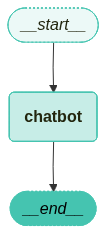

In [9]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [10]:
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 서울에는 다양한 맛집이 많아서 선택하기가 쉽지 않지만, 다음은 서울에서 유명한 맛집 TOP 10을 추천해 드립니다. 각 식당은 고유의 매력을 가지고 있으니 참고해 보세요!

1. **광장시장** - 전통 시장으로, 빈대떡, 마약김밥, 떡볶이 등 다양한 길거리 음식을 즐길 수 있습니다.

2. **부암동 카페거리** - 예쁜 카페와 맛있는 디저트가 많은 곳으로, 특히 '카페 드 파리'의 생과일 빙수가 유명합니다.

3. **이태원 앤틱 가구 거리** - 다양한 국제 요리를 즐길 수 있는 곳으로, 특히 '부리또'와 '타이 음식'이 인기입니다.

4. **명동 교자** - 칼국수와 만두가 유명한 맛집으로, 항상 많은 사람들이 줄 서서 기다립니다.

5. **삼청동 수제비** - 전통 수제비와 함께 다양한 한식을 즐길 수 있는 곳입니다.

6. **신사동 가로수길** - 다양한 트렌디한 레스토랑과 카페가 모여 있는 곳으로, 특히 '브런치' 메뉴가 인기입니다.

7. **종로 통인시장** - 다양한 전통 음식을 저렴하게 즐길 수 있는 시장으로, 특히 '김밥'과 '떡'이 유명합니다.

8. **홍대** - 다양한 음식점과 카페가 밀집해 있는 지역으로, 특히 '버거'와 '퓨전 음식'이 인기가 많습니다.

9. **압구정 로데오거리** - 고급 레스토랑과 카페가 많은 곳으로, 특히 '스테이크'와 '일식'이 유명합니다.

10. **강남역** - 다양한 패스트푸드와 한식, 중식, 일식 등 다양한 음식을 즐길 수 있는 곳으로, 특히 '치킨'과 '피자'가 인기입니다.

각 지역마다 특색 있는 음식들이 많으니, 방문하실 때 참고하시기 바랍니다!


In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_teddynote.graphs import visualize_graph


###### STEP 1. 상태(State) 정의 ######
class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]


###### STEP 2. 노드(Node) 정의 ######
# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}


###### STEP 3. 그래프(Graph) 정의, 노드 추가 ######
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

###### STEP 4. 그래프 엣지(Edge) 추가 ######
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

###### STEP 5. 그래프 컴파일(compile) ######
# 그래프 컴파일
graph = graph_builder.compile()

###### STEP 6. 그래프 시각화 ######
# 그래프 시각화
visualize_graph(graph)

###### STEP 7. 그래프 실행 ######
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print(value["messages"][-1].content)